<a href="https://colab.research.google.com/github/LeoFernanndes/portfolio/blob/master/Twitter_Scaping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install mysql-connector-python
!pip install pymysql
!pip install tweepy

In [12]:
import pandas as pd
import json
import mysql.connector
import os
import tweepy as tw
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option("display.max_rows", 500)

In [13]:
def twitter_authentication(twitter_api_credentials):

  auth = tw.OAuthHandler(consumer_key = twitter_api_credentials['consumer_key'],
                         consumer_secret = twitter_api_credentials['consumer_secret'])
  
  auth.set_access_token(twitter_api_credentials['access_token'],
                        twitter_api_credentials['access_secret'])
  
  api = tw.API(auth, wait_on_rate_limit=True)
  
  return api

In [14]:
def mysql_rds_database_authentication(database_credentials, database):
  
  mydb = mysql.connector.connect(
    host = database_credentials['host'],
    user = database_credentials['user'],
    port = database_credentials['port'],
    password = database_credentials['password'],
    database = database
  )

  return mydb

In [17]:
import mysql.connector
import pandas as pd

mydb = mysql_rds_database_authentication(twitter_database_credentials, 'twitter_data')

df = pd.read_sql("SELECT * FROM executed_queries", con=mydb)
df.sort_values(by=['date']).head()

,query,date,value,retrieved_tweets,minutes_to_retrieve
65,alura - 2020-09-29 - 2020-09-30,2020-10-05 15:18:29,alura,45,0
66,alura - 2020-09-30 - 2020-10-01,2020-10-05 15:18:34,alura,14,0
67,alura - 2020-10-01 - 2020-10-02,2020-10-05 15:19:10,alura,161,1
68,alura - 2020-10-02 - 2020-10-03,2020-10-05 15:19:26,alura,63,0
69,alura - 2020-10-03 - 2020-10-04,2020-10-05 15:19:56,alura,126,1


In [15]:
twitter_database_credentials = open("twitter_database_credentials.json")
twitter_database_credentials = json.load(twitter_database_credentials)

mydb = mysql_rds_database_authentication(twitter_database_credentials, 'twitter_data')

cursor = mydb.cursor()

cursor.execute(
    """
    USE twitter_data
    """
)

cursor.execute(
    """
    CREATE TABLE IF NOT EXISTS `executed_queries` (
      query VARCHAR(100) PRIMARY KEY,
      date DATETIME,
      value TEXT,
      retrieved_tweets INT,
      minutes_to_retrieve INT
    );
    """
)

cursor.execute(
    """
    CREATE TABLE IF NOt EXISTS `tweets` (
      id VARCHAR(50) PRIMARY KEY,
      name TEXT,
      arroba TEXT,
      retweetS INT,
      likes INT,
      text TEXT,
      date DATETIME,
      location TEXT,
      hashtags TEXT,
      links TEXT,
      language TEXT,
      search TEXT
    );
    """
)


twitter_api_credentials = open("twitter_keys.json")
twitter_api_credentials = json.load(twitter_api_credentials)

api = twitter_authentication(twitter_api_credentials)

# definindo a busca
search_words_list = ["carapicuíba"]

for word in search_words_list:

  dias = 6

  for i in range(dias):

    start = datetime.now()

    inicio = (datetime.today() - timedelta(days=((dias-i)-1), hours=3)).date()
    final = (datetime.today() - timedelta(days=((dias-i)-2), hours=3)).date()

    df = pd.read_sql("SELECT * FROM executed_queries", con=mydb)

    query = "{} - {} - {}".format(word, inicio, final)

    if query not in list(df["query"]):

      search_word = word
      date_since = inicio
      date_until = final

      tweets = tw.Cursor(api.search,
                        q=search_word,
                        tweet_mode="extended",
                        since=date_since,
                        until=date_until).items()

      count = 0

      for tweet in tweets:
        if hasattr(tweet, "quoted_status"):
          full_text = "QT {} \n QUOTED: {}".format(tweet.full_text, tweet.quoted_status.full_text)    
        if hasattr(tweet, "retweeted_status") is False:
          full_text = "{}".format(tweet.full_text)
        if hasattr(tweet, "retweeted_status") is True:
          full_text = "RT @{}: {}".format(tweet.retweeted_status.user.screen_name, tweet.retweeted_status.full_text)
       
        sql =  """
          INSERT IGNORE INTO `tweets` (id, name, arroba, retweets, likes, text, date, location, hashtags, links, language, search)
          VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
          """

        cursor.execute(
              sql, (tweet.id_str, tweet.user.name, tweet.user.screen_name, tweet.retweet_count, tweet.favorite_count, full_text,
                    tweet.created_at - timedelta(hours=3), tweet.user.location, str(tweet.entities.get("hashtags")), str(tweet.entities.get("urls")), tweet.lang, word)
          )

        count += 1

      mydb.commit()

      end = datetime.now()
      time = end - start
      minutes = time.seconds / 60

      if i != dias - 1:
        query_sql = """
          INSERT IGNORE INTO `executed_queries` (query, date, value, retrieved_tweets, minutes_to_retrieve)
          VALUES (%s, %s, %s, %s, %s)
        """
        cursor.execute(
            query_sql, ("{} - {} - {}".format(word, inicio, final), datetime.now(), word, count, np.round(minutes, 6))
        )

        mydb.commit()       

      print("{}: {} - {} retrieved {} in {}".format(word, inicio, final, count, np.round(time.seconds / 60, 4)))

mydb.close()

carapicuíba: 2020-12-16 - 2020-12-17 retrieved 114 in 0.0333


In [16]:
twitter_database_credentials = open("twitter_database_credentials.json")
twitter_database_credentials = json.load(twitter_database_credentials)

mydb = mysql_rds_database_authentication(twitter_database_credentials, 'twitter_data')

df_tweets = pd.read_sql("SELECT * FROM tweets where search = 'bolsonaro';", con=mydb)
df_tweets.sort_values(by=['date'], ascending=False).iloc[0:10]

,id,name,arroba,retweetS,likes,text,date,location,hashtags,links,language,search
1285757,1339397070638239746,gantune,gantune1,0,0,"Esse é um exemplo, Bolsonaro tem d olhar para ...",2020-12-16 23:28:41,,[],"[{'url': 'https://t.co/K8YfMjv54A', 'expanded_...",pt,bolsonaro
1285756,1339397069770027008,elon musk,Chiiitoge,0,0,@indio_vaginal Obrigada Bolsonaro 👍,2020-12-16 23:28:40,puta que pariu,[],[],pt,bolsonaro
1285755,1339397066569691137,Roberto,Roberto59985870,22,0,RT @alelacerdapro: Bolsonaro termina o ano do ...,2020-12-16 23:28:40,,[],[],pt,bolsonaro
1285754,1339397060232142850,Jones Manoel,_makavelijones,0,0,"acabei de ver a tabela. O Vascão, que é o club...",2020-12-16 23:28:38,Canudos,[],[],pt,bolsonaro
1285753,1339397056193056768,bruna,bruna90s,168,0,RT @carlaayres: Bolsonaro não tinha nem plano ...,2020-12-16 23:28:37,Belory hills,[],[],pt,bolsonaro
1285752,1339397055794589698,💃💃💃#mulheresderrubambolsonaro,MariaLucianeAR,8,0,RT @farias_leonidas: Ta explicado a insanidade...,2020-12-16 23:28:37,"Itapetininga, Brasil",[],"[{'url': 'https://t.co/PYRil52Llp', 'expanded_...",pt,bolsonaro
1285751,1339397054863450112,‏ً,lalisavxge,0,0,mano não aguento mais ver o alex defendo a por...,2020-12-16 23:28:37,ana clara ᥫ᭡,[],[],pt,bolsonaro
1285749,1339397043094216707,Dafner,JaderDeconto,0,0,@quehorrorlais Lula1 razoável(equipe do Palocc...,2020-12-16 23:28:34,,[],[],pt,bolsonaro
1285748,1339397042414755841,Vilma Thomas Costa,VilmaThomasCos1,0,0,Vejam o vídeo todo. Simplesmente Lindooooooooo...,2020-12-16 23:28:34,,[],"[{'url': 'https://t.co/MQ83s4tSCc', 'expanded_...",pt,bolsonaro
1285750,1339397043966664705,Twitt Skipper,twittskipper,0,0,@davialcolumbre @SenadoFederal Vc deveria ter ...,2020-12-16 23:28:34,Brasil,[],[],pt,bolsonaro


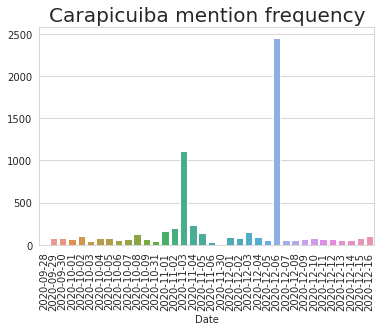

In [18]:
mydb = mysql_rds_database_authentication(twitter_database_credentials, 'twitter_data')

search = "carapicuiba"

df = pd.read_sql("SELECT * FROM tweets WHERE search LIKE '%{}%'".format(search), con=mydb)
df["date_date"] = [date.date() for date in df["date"]]
datas = df.groupby(by="date_date").count()

datas_values = datas["id"].values
datas_index = datas.index

sns.set_style("whitegrid")
plt.title("{} mention frequency".format(search.capitalize()), fontdict={"fontsize":20})
plot = sns.barplot(x=datas_index, y=datas_values)
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.show()

In [19]:
import mysql.connector
import os
import tweepy as tw
import pandas as pd
from datetime import datetime, timedelta
import numpy as np


def retrieve_last_300_tweets(search_word, twitter_api_credentials, database_credentials, database):

  api = twitter_authentication(twitter_api_credentials)


  start = datetime.now()
  tweets = tw.Cursor(api.search,
                    q=search_word,
                    tweet_mode="extended").items(300)

  count = 0

  # connect to mysql db
  mydb = mysql_rds_database_authentication(database_credentials, database)
  cursor = mydb.cursor()

  for tweet in tweets:
    if hasattr(tweet, "quoted_status"):
      full_text = "QT {} \n QUOTED: {}".format(tweet.full_text, tweet.quoted_status.full_text)    
    if hasattr(tweet, "retweeted_status") is False:
      full_text = "{}".format(tweet.full_text)
    if hasattr(tweet, "retweeted_status") is True:
      full_text = "RT @{}: {}".format(tweet.retweeted_status.user.screen_name, tweet.retweeted_status.full_text)
    
    sql =  """
      INSERT IGNORE INTO `tweets` (id, name, arroba, retweets, likes, text, date, location, hashtags, links, language, search)
      VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
      """

    cursor.execute(
          sql, (tweet.id_str, tweet.user.name, tweet.user.screen_name, tweet.retweet_count, tweet.favorite_count, full_text,
                tweet.created_at - timedelta(hours=3), tweet.user.location, str(tweet.entities.get("hashtags")), str(tweet.entities.get("urls")), tweet.lang, search_word)
      )

    
    count += 1

    # print(tweet.user.name, count)

  mydb.commit()

  end = datetime.now()
  time = end - start
  minutes = time.seconds / 60

  mydb.close()

  print("{}: retrieved {} in {}".format(word, count, np.round(time.seconds, 2)))

In [20]:
retrieve_last_300_tweets('carapicuiba', twitter_api_credentials, twitter_database_credentials, 'twitter_data')

carapicuíba: retrieved 300 in 7
